# MF-DMA (Multifractal Detrended Moving Average) Module

Reference:

Gu, Gao-Feng Gu, and Wei-Xing Zhou. "Detrending moving average algorithm for multifractals." Physical Review E, no. 82, 2010, pp. 011136,

Arianos, Sergio, and Anna Carbone. "Detrending moving average algorithm: A closed-form approximation of the scaling law." Physica A, no. 382, 2007, pp. 9–15,

Wang, Yudong, et al. “Multifractal Detrending Moving Average Analysis on The US Dollar Exchange Rates.” Physica A, no. 390, 2011, pp. 3512–3523.

In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import time

import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow as tf

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
files = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/SPX_1m_May2022_Nov2022.csv'
df0 = pd.read_csv(files)
df0

,Time,Price
0,5/1/2022 18:00,4140.436
1,5/1/2022 18:01,4146.245
2,5/1/2022 18:02,4147.945
3,5/1/2022 18:03,4151.999
4,5/1/2022 18:04,4151.351
...,...,...
202842,11/30/2022 23:55,4082.990
202843,11/30/2022 23:56,4082.749
202844,11/30/2022 23:57,4082.761
202845,11/30/2022 23:58,4083.018


Split dadasets by daylight savings time (Nov. 6, 2022)

In [4]:
df0[df0['Time']=='11/6/2022 18:00'].index

Index([178931], dtype='int64')

In [5]:
df0[df0['Time']=='11/30/2022 10:15'].index

Index([202128], dtype='int64')

In [6]:
df1 = df0[:178931] # Daylight savings time
df2 = df0[178931:202128] # Not daylight savings time

In [7]:
# Set timestamp as index
df1 = df1.set_index(df1['Time'])
df1.drop(['Time'], axis=1, inplace=True)
df1.index = pd.to_datetime(df1.index)

df2 = df2.set_index(df2['Time'])
df2.drop(['Time'], axis=1, inplace=True)
df2.index = pd.to_datetime(df2.index)

# Adjust dataset to closing price of VIX in U.S., i.e., modified GMT 23:59:00 --> 15:14:00 in the U.S. Cboe
df1.index = df1.index + pd.DateOffset(hours=12, minutes=45)
df2.index = df2.index + pd.DateOffset(hours=13, minutes=45)

In [8]:
df = pd.DataFrame(pd.concat([df1, df2]))
df

,Price
Time,
2022-05-02 06:45:00,4140.436
2022-05-02 06:46:00,4146.245
2022-05-02 06:47:00,4147.945
2022-05-02 06:48:00,4151.999
2022-05-02 06:49:00,4151.351
...,...
2022-11-30 23:55:00,3953.170
2022-11-30 23:56:00,3954.680
2022-11-30 23:57:00,3952.016


In [9]:
# Calculate log return
df['log_ret'] = 10000 * np.log(df.Price).diff() # 10,000 times log return

# Calculate the time difference in mininutes
df['deltaT'] = (df.index.to_series().diff().dt.days.mul(60*24, fill_value=0) +
                df.index.to_series().diff().dt.seconds.div(60, fill_value=0)
               )
df['missingT'] = df['deltaT'] - 1

df_1min = df[df['deltaT'] == 1]
df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])
df_1min

C:\Users\cutef\AppData\Local\Temp\ipykernel_17684\4091110551.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1min['log_ret_sq'] = np.square(df_1min['log_ret'])


,Price,log_ret,deltaT,missingT,log_ret_sq
Time,,,,,
2022-05-02 06:46:00,4146.245,14.020091,1.0,0.0,196.562943
2022-05-02 06:47:00,4147.945,4.099255,1.0,0.0,16.803892
2022-05-02 06:48:00,4151.999,9.768741,1.0,0.0,95.428308
2022-05-02 06:49:00,4151.351,-1.560816,1.0,0.0,2.436146
2022-05-02 06:50:00,4150.936,-0.999725,1.0,0.0,0.999449
...,...,...,...,...,...
2022-11-30 23:55:00,3953.170,-3.776003,1.0,0.0,14.258198
2022-11-30 23:56:00,3954.680,3.818990,1.0,0.0,14.584685
2022-11-30 23:57:00,3952.016,-6.738592,1.0,0.0,45.408628


In [10]:
# Change the setting to show 1000 rows
pd.set_option('display.max_rows', 1000)

## Slice dataset into daily, weekly and monthly segments

### Determine how many data points in a week on average

In [11]:
available_weekly =  df_1min['deltaT'].resample('1w').count().to_frame()

available_weekly

,deltaT
Time,
2022-05-08,6628
2022-05-15,6657
2022-05-22,6662
2022-05-29,6662
2022-06-05,6455
2022-06-12,6600
2022-06-19,6670
2022-06-26,6468
2022-07-03,6645


#### Method one: drop incomplete week data points

In [12]:
# Drop incomplete last week

available_weekly_drop = available_weekly.loc[available_weekly['deltaT']!=available_weekly['deltaT'].min()]

available_weekly_drop

,deltaT
Time,
2022-05-08,6628
2022-05-15,6657
2022-05-22,6662
2022-05-29,6662
2022-06-05,6455
2022-06-12,6600
2022-06-19,6670
2022-06-26,6468
2022-07-03,6645


In [13]:
avg_weekly1 = int(available_weekly_drop.mean())
avg_weekly1

C:\Users\cutef\AppData\Local\Temp\ipykernel_17684\2082506604.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_weekly1 = int(available_weekly_drop.mean())


6594

#### Method Two: don't drop incomplete weekly data points

In [14]:
avg_weekly = int(available_weekly.mean())
avg_weekly

C:\Users\cutef\AppData\Local\Temp\ipykernel_17684\2549662872.py:1: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  avg_weekly = int(available_weekly.mean())


6498

### Determine how many data points in a day on average

In [15]:
available_daily = df_1min['deltaT'].resample('1d').count().to_frame()
available_daily['day_of_week'] = available_daily.index.dayofweek
print(available_daily)

            deltaT  day_of_week
Time                           
2022-05-02    1034            0
2022-05-03    1328            1
2022-05-04    1317            2
2022-05-05    1315            3
2022-05-06    1334            4
2022-05-07     300            5
2022-05-08       0            6
2022-05-09    1034            0
2022-05-10    1326            1
2022-05-11    1329            2
2022-05-12    1334            3
2022-05-13    1334            4
2022-05-14     300            5
2022-05-15       0            6
2022-05-16    1034            0
2022-05-17    1330            1
2022-05-18    1330            2
2022-05-19    1334            3
2022-05-20    1334            4
2022-05-21     300            5
2022-05-22       0            6
2022-05-23    1034            0
2022-05-24    1330            1
2022-05-25    1332            2
2022-05-26    1332            3
2022-05-27    1334            4
2022-05-28     300            5
2022-05-29       0            6
2022-05-30    1032            0
2022-05-

We can combine Fridays and Sundays data to align with the other weekdays

In [16]:
# Average daily data availability
avg_daily = int(available_daily['deltaT'].mean() * 7 / 5) # No available data on Sundays
avg_daily

1324

### Determine how many data points in a month on average

In [17]:
available_monthly =  df_1min['deltaT'].resample('1m').count().to_frame()
available_monthly

,deltaT
Time,
2022-05-31,28777
2022-06-30,29037
2022-07-31,28025
2022-08-31,29865
2022-09-30,29022
2022-10-31,28065
2022-11-30,28650


In [18]:
avg_monthly = available_monthly['deltaT'][:-2].mean() # Discard December 2022 because of data incompleteness
avg_monthly

28945.2

### Determine conversion ratio between daily, weekly and monthly

In [19]:
ratio_weekly = int(round(avg_weekly / avg_daily, 0))
ratio_monthly = int(round(avg_monthly / avg_daily, 0))

print(f'Conversion ratio of weekly and monthly to daily are {ratio_weekly} and {ratio_monthly}, respectively')

Conversion ratio of weekly and monthly to daily are 5 and 22, respectively


In [20]:
modified_weekly_data = int(ratio_weekly * avg_daily)
modified_monthly_data = int(ratio_monthly * avg_daily)

print(f'We use {avg_daily}, {modified_weekly_data} \
and {modified_monthly_data} data points, respectively for daily, weekly and monthly available dataset')

We use 1324, 6620 and 29128 data points, respectively for daily, weekly and monthly available dataset


In [21]:
# Change the setting to show 200 rows
pd.set_option('display.max_rows', 200)

#### Prepare the dataframe of the modified dataset

In [22]:
modified_data = df_1min['log_ret_sq'].copy()

number_modified_data = len(modified_data) // avg_daily * avg_daily
modified_data = modified_data[-number_modified_data:]
modified_data

Time
2022-05-02 09:59:00     3.144911
2022-05-02 10:00:00     5.190602
2022-05-02 10:01:00    22.041691
2022-05-02 10:02:00     1.460127
2022-05-02 10:03:00     6.526182
                         ...    
2022-11-30 23:55:00    14.258198
2022-11-30 23:56:00    14.584685
2022-11-30 23:57:00    45.408628
2022-11-30 23:58:00    10.757592
2022-11-30 23:59:00     6.242957
Name: log_ret_sq, Length: 201248, dtype: float64

#### Determine how many observations in our final analysis

In [23]:
num_obs = int(len(modified_data) // avg_daily - ratio_monthly + 1)
num_obs

131

#### Resize the modified data into observation-numbered series

In [24]:
monthly_resized_data = pd.DataFrame(index=np.arange(modified_monthly_data), columns=np.arange(num_obs))

starttime_total = time.time()
       
for j in range(num_obs): 
    loc_start_modified_data = -((-j + num_obs + ratio_monthly - 1) * avg_daily)

    for i in range(modified_monthly_data):
        monthly_resized_data[j][i] = modified_data[loc_start_modified_data]
        loc_start_modified_data += 1
    
    if (j+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{j+1} out of {num_obs} monthly columns prepared,', 
              f'total time spent till now is {int((endtime_total-starttime_total)//60)} min(s)', 
              f'{int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'All monthly columns prepared!',
      f'Total time spent is {int((endtime_total-starttime_total)//60)} min',
      f'{int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 131 monthly columns prepared, total time spent till now is 0 min(s) 35 sec(s).
20 out of 131 monthly columns prepared, total time spent till now is 1 min(s) 10 sec(s).
30 out of 131 monthly columns prepared, total time spent till now is 1 min(s) 44 sec(s).
40 out of 131 monthly columns prepared, total time spent till now is 2 min(s) 21 sec(s).
50 out of 131 monthly columns prepared, total time spent till now is 2 min(s) 57 sec(s).
60 out of 131 monthly columns prepared, total time spent till now is 3 min(s) 33 sec(s).
70 out of 131 monthly columns prepared, total time spent till now is 4 min(s) 9 sec(s).
80 out of 131 monthly columns prepared, total time spent till now is 4 min(s) 44 sec(s).
90 out of 131 monthly columns prepared, total time spent till now is 5 min(s) 20 sec(s).
100 out of 131 monthly columns prepared, total time spent till now is 5 min(s) 56 sec(s).
110 out of 131 monthly columns prepared, total time spent till now is 6 min(s) 31 sec(s).
120 out of 131 month

In [25]:
monthly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,3.144911,2.015359,0.064255,3.570528,0.000843,1.509441,0.151953,9.081391,38.459015,0.658813,...,11.373861,15.242611,37.219862,15.349392,1.668171,0.488936,6.871742,0.000061,6.99182,0.22473
1,5.190602,0.047774,0.504392,0.000439,32.588028,0.271409,15.091005,1.52439,102.124155,0.760882,...,28.442796,52.030649,37.418694,14.282833,18.838405,4.011438,50.691752,6.518876,0.962521,0.031601
2,22.041691,0.643613,0.395466,0.000195,2.478657,0.002663,24.363936,2.271935,46.551288,0.023012,...,1.958214,10.798168,0.001655,4.16685,69.563188,10.764362,20.318253,1.566871,5.48764,4.850931
3,1.460127,17.637286,3.104762,0.000049,28.559226,24.240754,1.562746,3.168576,18.696593,8.978864,...,10.245599,6.4358,1.853651,0.001933,2.806578,7.0513,6.496405,0.353591,10.801931,1.800588
4,6.526182,0.001871,1.515576,0.191441,3.609183,21.674835,5.592271,10.229665,3.13591,12.211784,...,0.517782,45.614734,4.093803,0.116084,5.571798,0.096992,0.474189,6.968391,0.444093,2.708656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29123,9.794408,0.5239,0.202339,8.611315,0.216867,3.56917,0.0,1.585378,0.330683,28.259591,...,0.003958,25.43511,0.020053,0.440466,1.613939,3.56953,5.964877,31.150723,9.708752,14.258198
29124,0.461058,23.747355,1.380052,5.923598,3.746818,0.245848,2.522197,1.547616,0.094276,10.27761,...,0.000228,0.087881,0.018646,3.543222,0.380029,0.067762,11.55701,46.739554,25.355074,14.584685
29125,3.627076,2.958201,1.453752,0.279778,2.203473,0.969074,1.021774,1.020387,15.166996,2.54349,...,17.006737,16.918033,1.624533,1.623989,24.385243,0.873451,0.102356,30.727089,25.839835,45.408628
29126,0.238855,9.988729,11.10029,5.170135,0.964853,0.211307,0.492173,0.932099,2.460309,1.182199,...,7.940401,6.4269,3.560265,1.623989,0.361477,0.001383,3.627319,1.576496,30.268397,10.757592


In [26]:
weekly_resized_data = pd.DataFrame(index=np.arange(modified_weekly_data), columns=np.arange(num_obs))

starttime_total = time.time()
       
for j in range(num_obs): 
    loc_start_modified_data = -((-j + num_obs + ratio_weekly - 1) * avg_daily)
    
    for i in range(modified_weekly_data):
        weekly_resized_data[j][i] = modified_data[loc_start_modified_data]
        loc_start_modified_data += 1
    
    if (j+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{j+1} out of {num_obs} weekly columns prepared,',
              f'total time spent till now is {int((endtime_total-starttime_total)//60)} min(s)', 
              f'{int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'All weekly columns prepared!',
      f'Total time spent is {int((endtime_total-starttime_total)//60)} min',
      f'{int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 5 sec(s).
20 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 10 sec(s).
30 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 16 sec(s).
40 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 21 sec(s).
50 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 26 sec(s).
60 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 32 sec(s).
70 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 37 sec(s).
80 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 43 sec(s).
90 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 48 sec(s).
100 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 53 sec(s).
110 out of 131 weekly columns prepared, total time spent till now is 0 min(s) 59 sec(s).
120 out of 131 weekly columns p

In [27]:
weekly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,2.337286,0.118675,0.236004,1.44068,14.069132,0.013354,1.521483,1.37926,1.787433,6.122548,...,0.103696,26.795572,13.161513,6.431896,0.307221,14.160108,1.550566,1.639635,2.349918,0.427216
1,0.584277,2.276517,0.221847,2.136715,0.216838,0.001878,1.450527,0.535603,3.427662,1.503425,...,0.497321,3.550652,3.624203,3.303576,0.662401,6.361101,4.866492,0.627355,0.000924,6.222497
2,0.000916,0.055886,4.070061,0.340162,0.550176,5.693427,0.54581,0.546157,3.427662,0.000481,...,3.984042,18.131008,24.921218,14.240004,4.059617,0.026708,2.059572,0.603629,0.354473,5.428144
3,3.952829,1.962022,0.024147,0.3717,1.355661,7.577782,0.24502,1.499407,1.21855,3.661453,...,4.123338,3.407157,13.973015,0.390956,6.038408,0.191375,0.642119,14.187185,0.239064,0.016188
4,0.059907,0.017098,0.383303,0.921787,0.237537,4.210748,10.052078,0.242707,1.524972,15.271011,...,2.582948,16.726375,0.383815,0.432789,0.675253,0.111804,0.451584,9.156325,3.609264,0.40787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6615,9.794408,0.5239,0.202339,8.611315,0.216867,3.56917,0.0,1.585378,0.330683,28.259591,...,0.003958,25.43511,0.020053,0.440466,1.613939,3.56953,5.964877,31.150723,9.708752,14.258198
6616,0.461058,23.747355,1.380052,5.923598,3.746818,0.245848,2.522197,1.547616,0.094276,10.27761,...,0.000228,0.087881,0.018646,3.543222,0.380029,0.067762,11.55701,46.739554,25.355074,14.584685
6617,3.627076,2.958201,1.453752,0.279778,2.203473,0.969074,1.021774,1.020387,15.166996,2.54349,...,17.006737,16.918033,1.624533,1.623989,24.385243,0.873451,0.102356,30.727089,25.839835,45.408628
6618,0.238855,9.988729,11.10029,5.170135,0.964853,0.211307,0.492173,0.932099,2.460309,1.182199,...,7.940401,6.4269,3.560265,1.623989,0.361477,0.001383,3.627319,1.576496,30.268397,10.757592


In [28]:
daily_resized_data = pd.DataFrame(index=np.arange(avg_daily), columns=np.arange(num_obs))

starttime_total = time.time()
       
for j in range(num_obs): 
    loc_start_modified_data = -((-j + num_obs) * avg_daily)

    for i in range(avg_daily):
        daily_resized_data[j][i] = modified_data[loc_start_modified_data]
        loc_start_modified_data += 1
    
    if (j+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{j+1} out of {num_obs} daily columns prepared,',
              f'total time spent till now is {int((endtime_total-starttime_total)//60)} min(s)', 
              f'{int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()        
total_time = endtime_total - starttime_total
print(f'All daily columns prepared!',
      f'Total time spent is {int((endtime_total-starttime_total)//60)} min',
      f'{int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 131 daily columns prepared, total time spent till now is 0 min(s) 0 sec(s).
20 out of 131 daily columns prepared, total time spent till now is 0 min(s) 1 sec(s).
30 out of 131 daily columns prepared, total time spent till now is 0 min(s) 2 sec(s).
40 out of 131 daily columns prepared, total time spent till now is 0 min(s) 3 sec(s).
50 out of 131 daily columns prepared, total time spent till now is 0 min(s) 4 sec(s).
60 out of 131 daily columns prepared, total time spent till now is 0 min(s) 5 sec(s).
70 out of 131 daily columns prepared, total time spent till now is 0 min(s) 6 sec(s).
80 out of 131 daily columns prepared, total time spent till now is 0 min(s) 7 sec(s).
90 out of 131 daily columns prepared, total time spent till now is 0 min(s) 8 sec(s).
100 out of 131 daily columns prepared, total time spent till now is 0 min(s) 9 sec(s).
110 out of 131 daily columns prepared, total time spent till now is 0 min(s) 10 sec(s).
120 out of 131 daily columns prepared, total time s

In [29]:
daily_resized_data

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,14.069132,0.013354,1.521483,1.37926,1.787433,6.122548,2.837741,0.794782,0.557236,0.076061,...,0.307221,14.160108,1.550566,1.639635,2.349918,0.427216,1.518209,0.330886,76.107441,0.251665
1,0.216838,0.001878,1.450527,0.535603,3.427662,1.503425,1.517714,1.900814,15.074637,0.270797,...,0.662401,6.361101,4.866492,0.627355,0.000924,6.222497,0.063953,0.339498,7.121144,0.010682
2,0.550176,5.693427,0.54581,0.546157,3.427662,0.000481,2.828941,0.534045,4.115223,0.561596,...,4.059617,0.026708,2.059572,0.603629,0.354473,5.428144,0.099139,4.683933,0.013839,37.65448
3,1.355661,7.577782,0.24502,1.499407,1.21855,3.661453,1.471148,0.244497,0.073596,1.733923,...,6.038408,0.191375,0.642119,14.187185,0.239064,0.016188,0.357012,0.901248,3.440699,9.951714
4,0.237537,4.210748,10.052078,0.242707,1.524972,15.271011,0.224781,1.39571,2.274539,0.659265,...,0.675253,0.111804,0.451584,9.156325,3.609264,0.40787,9.470045,0.383984,75.269958,18.971553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,9.794408,0.5239,0.202339,8.611315,0.216867,3.56917,0.0,1.585378,0.330683,28.259591,...,0.003958,25.43511,0.020053,0.440466,1.613939,3.56953,5.964877,31.150723,9.708752,14.258198
1320,0.461058,23.747355,1.380052,5.923598,3.746818,0.245848,2.522197,1.547616,0.094276,10.27761,...,0.000228,0.087881,0.018646,3.543222,0.380029,0.067762,11.55701,46.739554,25.355074,14.584685
1321,3.627076,2.958201,1.453752,0.279778,2.203473,0.969074,1.021774,1.020387,15.166996,2.54349,...,17.006737,16.918033,1.624533,1.623989,24.385243,0.873451,0.102356,30.727089,25.839835,45.408628
1322,0.238855,9.988729,11.10029,5.170135,0.964853,0.211307,0.492173,0.932099,2.460309,1.182199,...,7.940401,6.4269,3.560265,1.623989,0.361477,0.001383,3.627319,1.576496,30.268397,10.757592


In [30]:
# Prepare the final dataframe to analyze
final_data_cols = ['H_Daily', 'H_Weekly', 'H_Monthly', 'Real_VIX']
final_data = pd.DataFrame(index=np.arange(num_obs), columns=final_data_cols)
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN


# Analyze daily cleaned data

In [31]:
daily_resized_data

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,14.069132,0.013354,1.521483,1.37926,1.787433,6.122548,2.837741,0.794782,0.557236,0.076061,...,0.307221,14.160108,1.550566,1.639635,2.349918,0.427216,1.518209,0.330886,76.107441,0.251665
1,0.216838,0.001878,1.450527,0.535603,3.427662,1.503425,1.517714,1.900814,15.074637,0.270797,...,0.662401,6.361101,4.866492,0.627355,0.000924,6.222497,0.063953,0.339498,7.121144,0.010682
2,0.550176,5.693427,0.54581,0.546157,3.427662,0.000481,2.828941,0.534045,4.115223,0.561596,...,4.059617,0.026708,2.059572,0.603629,0.354473,5.428144,0.099139,4.683933,0.013839,37.65448
3,1.355661,7.577782,0.24502,1.499407,1.21855,3.661453,1.471148,0.244497,0.073596,1.733923,...,6.038408,0.191375,0.642119,14.187185,0.239064,0.016188,0.357012,0.901248,3.440699,9.951714
4,0.237537,4.210748,10.052078,0.242707,1.524972,15.271011,0.224781,1.39571,2.274539,0.659265,...,0.675253,0.111804,0.451584,9.156325,3.609264,0.40787,9.470045,0.383984,75.269958,18.971553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,9.794408,0.5239,0.202339,8.611315,0.216867,3.56917,0.0,1.585378,0.330683,28.259591,...,0.003958,25.43511,0.020053,0.440466,1.613939,3.56953,5.964877,31.150723,9.708752,14.258198
1320,0.461058,23.747355,1.380052,5.923598,3.746818,0.245848,2.522197,1.547616,0.094276,10.27761,...,0.000228,0.087881,0.018646,3.543222,0.380029,0.067762,11.55701,46.739554,25.355074,14.584685
1321,3.627076,2.958201,1.453752,0.279778,2.203473,0.969074,1.021774,1.020387,15.166996,2.54349,...,17.006737,16.918033,1.624533,1.623989,24.385243,0.873451,0.102356,30.727089,25.839835,45.408628
1322,0.238855,9.988729,11.10029,5.170135,0.964853,0.211307,0.492173,0.932099,2.460309,1.182199,...,7.940401,6.4269,3.560265,1.623989,0.361477,0.001383,3.627319,1.576496,30.268397,10.757592


In [32]:
# Define parameters
n_sample = avg_daily
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
# qs = list(np.linspace(-10, 10, num=41, endpoint=True))
qs = [2.0]

daily_cumsum = daily_resized_data.cumsum(axis=0)
daily_cumsum

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,14.069132,0.013354,1.521483,1.37926,1.787433,6.122548,2.837741,0.794782,0.557236,0.076061,...,0.307221,14.160108,1.550566,1.639635,2.349918,0.427216,1.518209,0.330886,76.107441,0.251665
1,14.285971,0.015231,2.97201,1.914863,5.215095,7.625973,4.355455,2.695596,15.631873,0.346858,...,0.969622,20.521209,6.417058,2.26699,2.350843,6.649713,1.582162,0.670383,83.228585,0.262347
2,14.836147,5.708659,3.517821,2.461021,8.642757,7.626455,7.184395,3.22964,19.747096,0.908454,...,5.02924,20.547917,8.47663,2.870619,2.705315,12.077857,1.681301,5.354316,83.242425,37.916827
3,16.191808,13.286441,3.762841,3.960428,9.861307,11.287908,8.655543,3.474138,19.820692,2.642377,...,11.067648,20.739293,9.118749,17.057804,2.944379,12.094045,2.038313,6.255564,86.683123,47.868541
4,16.429345,17.497189,13.814919,4.203135,11.386279,26.558919,8.880324,4.869847,22.095231,3.301642,...,11.742901,20.851097,9.570333,26.214129,6.553643,12.501915,11.508358,6.639548,161.953082,66.840094
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,23780.691673,20629.577097,17364.640834,19629.82339,14320.377211,13557.81559,11770.113499,19151.038546,42645.467636,39826.295619,...,11612.838091,12631.881109,11681.302818,7340.271894,5518.020972,8143.053006,1658.944117,4381.254133,7094.358349,8637.509096
1320,23781.152731,20653.324452,17366.020886,19635.746988,14324.124029,13558.061437,11772.635696,19152.586162,42645.561912,39836.573229,...,11612.838319,12631.968989,11681.321465,7343.815116,5518.401002,8143.120768,1670.501127,4427.993687,7119.713422,8652.093781
1321,23784.779807,20656.282654,17367.474638,19636.026767,14326.327502,13559.030511,11773.65747,19153.606549,42660.728908,39839.116719,...,11629.845056,12648.887022,11682.945997,7345.439105,5542.786245,8143.994219,1670.603483,4458.720776,7145.553257,8697.502409
1322,23785.018662,20666.271383,17378.574928,19641.196902,14327.292355,13559.241818,11774.149643,19154.538649,42663.189216,39840.298918,...,11637.785457,12655.313922,11686.506262,7347.063094,5543.147723,8143.995602,1674.230802,4460.297271,7175.821654,8708.26


## In the for-loop:
### 1. Construct the sequence of cumulative sums
### 2. Calculate moving average
### 3. Detrend
### 4. Define non-overlapping segments and calculate each fluctuation variance
### 5. Calculate q-th order fluctuation function

In [33]:
# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    for col in range(num_obs):
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_daily = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_daily

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_121,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130
s_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in range(num_obs):
    ana_temp = daily_cumsum[col]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_daily.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_daily[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data['H_Daily'][col] = hurst_hat
    
    if (col+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 131 columns are done, total time spent till now is 1 min(s) 0 sec(s).
20 out of 131 columns are done, total time spent till now is 2 min(s) 1 sec(s).
30 out of 131 columns are done, total time spent till now is 3 min(s) 1 sec(s).
40 out of 131 columns are done, total time spent till now is 4 min(s) 2 sec(s).
50 out of 131 columns are done, total time spent till now is 5 min(s) 2 sec(s).
60 out of 131 columns are done, total time spent till now is 6 min(s) 4 sec(s).
70 out of 131 columns are done, total time spent till now is 7 min(s) 4 sec(s).
80 out of 131 columns are done, total time spent till now is 8 min(s) 4 sec(s).
90 out of 131 columns are done, total time spent till now is 9 min(s) 5 sec(s).
100 out of 131 columns are done, total time spent till now is 10 min(s) 6 sec(s).
110 out of 131 columns are done, total time spent till now is 11 min(s) 6 sec(s).
120 out of 131 columns are done, total time spent till now is 12 min(s) 7 sec(s).
130 out of 131 columns are done, t

In [35]:
F_summary_daily

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_121,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130
s_3,11.209581,8.765038,11.355832,13.519504,8.847634,10.596066,6.332917,10.697293,77.435814,18.283502,...,6.128362,7.457455,5.680156,3.970002,3.27562,10.32791,1.081803,2.677009,6.728459,5.798756
s_4,11.637388,9.791255,12.342496,14.390728,9.291958,10.190874,7.281009,10.763475,107.18895,20.465596,...,8.526695,9.661782,6.158241,4.619188,3.374327,8.488281,1.274398,2.494894,8.86198,7.216747
s_5,12.602586,10.189921,11.718303,12.997416,11.317467,12.326458,7.638551,11.434757,86.464878,21.701035,...,9.80392,8.237968,6.688344,4.745738,3.5178,9.964765,1.236579,2.257368,9.138191,6.312289
s_6,12.025225,10.827949,11.962441,14.007656,10.129376,12.518195,6.966192,13.129861,82.327957,20.4367,...,8.157113,9.701068,6.779942,4.801912,3.823027,13.749563,1.426226,2.98008,10.118812,7.994442
s_7,13.582877,11.539751,11.812967,14.375223,12.398716,12.443742,7.218182,12.988873,83.405826,21.763832,...,9.796375,8.776211,6.860844,4.453201,3.628522,13.079615,1.34212,2.679405,8.955868,7.236372
s_8,12.39543,12.177287,14.61684,14.308806,12.198957,12.626095,7.635437,14.547623,133.588871,22.729145,...,9.846105,9.650761,7.233078,5.931592,3.656643,9.235988,1.223312,2.700496,10.487255,7.433616
s_9,12.559686,11.98711,14.32049,13.708547,10.479842,12.314089,7.103864,14.378484,136.904606,23.223281,...,10.49528,9.219816,7.27387,5.678454,4.024654,10.858274,1.399347,3.089649,10.544795,7.526014
s_10,12.803706,11.339254,13.012396,17.653883,11.237153,11.243477,7.715208,13.807527,136.302775,22.01613,...,10.054066,8.245018,6.666656,5.431385,3.856694,15.634873,1.21316,3.711269,11.010042,8.206218
s_11,12.76173,12.955737,13.449956,13.825406,13.141466,11.764022,7.915919,15.709213,90.083751,23.830249,...,10.020002,9.382386,7.052663,6.208254,3.986396,15.445746,1.557665,2.379103,12.051848,8.178137
s_12,12.974222,11.977003,15.340827,14.314828,11.384092,11.480997,7.695783,16.153312,131.371226,20.461575,...,12.253936,9.426083,6.884067,6.890283,4.107293,15.436545,1.422487,3.734168,10.8289,7.834202


In [36]:
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.340135,NaN,NaN,NaN
1,0.305039,NaN,NaN,NaN
2,0.398033,NaN,NaN,NaN
3,0.311613,NaN,NaN,NaN
4,0.28453,NaN,NaN,NaN
5,0.223343,NaN,NaN,NaN
6,0.240975,NaN,NaN,NaN
7,0.289382,NaN,NaN,NaN
8,0.138345,NaN,NaN,NaN
9,0.332009,NaN,NaN,NaN


In [37]:
# Save temp result
final_data.to_csv('final_data_May2022-Nov2022_daily_08162023.csv')

# Analyze weekly cleaned data

In [38]:
weekly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,2.337286,0.118675,0.236004,1.44068,14.069132,0.013354,1.521483,1.37926,1.787433,6.122548,...,0.103696,26.795572,13.161513,6.431896,0.307221,14.160108,1.550566,1.639635,2.349918,0.427216
1,0.584277,2.276517,0.221847,2.136715,0.216838,0.001878,1.450527,0.535603,3.427662,1.503425,...,0.497321,3.550652,3.624203,3.303576,0.662401,6.361101,4.866492,0.627355,0.000924,6.222497
2,0.000916,0.055886,4.070061,0.340162,0.550176,5.693427,0.54581,0.546157,3.427662,0.000481,...,3.984042,18.131008,24.921218,14.240004,4.059617,0.026708,2.059572,0.603629,0.354473,5.428144
3,3.952829,1.962022,0.024147,0.3717,1.355661,7.577782,0.24502,1.499407,1.21855,3.661453,...,4.123338,3.407157,13.973015,0.390956,6.038408,0.191375,0.642119,14.187185,0.239064,0.016188
4,0.059907,0.017098,0.383303,0.921787,0.237537,4.210748,10.052078,0.242707,1.524972,15.271011,...,2.582948,16.726375,0.383815,0.432789,0.675253,0.111804,0.451584,9.156325,3.609264,0.40787
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6615,9.794408,0.5239,0.202339,8.611315,0.216867,3.56917,0.0,1.585378,0.330683,28.259591,...,0.003958,25.43511,0.020053,0.440466,1.613939,3.56953,5.964877,31.150723,9.708752,14.258198
6616,0.461058,23.747355,1.380052,5.923598,3.746818,0.245848,2.522197,1.547616,0.094276,10.27761,...,0.000228,0.087881,0.018646,3.543222,0.380029,0.067762,11.55701,46.739554,25.355074,14.584685
6617,3.627076,2.958201,1.453752,0.279778,2.203473,0.969074,1.021774,1.020387,15.166996,2.54349,...,17.006737,16.918033,1.624533,1.623989,24.385243,0.873451,0.102356,30.727089,25.839835,45.408628
6618,0.238855,9.988729,11.10029,5.170135,0.964853,0.211307,0.492173,0.932099,2.460309,1.182199,...,7.940401,6.4269,3.560265,1.623989,0.361477,0.001383,3.627319,1.576496,30.268397,10.757592


In [39]:
# Define parameters
n_sample = modified_weekly_data
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
# qs = list(np.linspace(-10, 10, num=41, endpoint=True))
qs = [2.0]

weekly_cumsum = weekly_resized_data.cumsum(axis=0)
weekly_cumsum

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,2.337286,0.118675,0.236004,1.44068,14.069132,0.013354,1.521483,1.37926,1.787433,6.122548,...,0.103696,26.795572,13.161513,6.431896,0.307221,14.160108,1.550566,1.639635,2.349918,0.427216
1,2.921563,2.395192,0.457851,3.577395,14.285971,0.015231,2.97201,1.914863,5.215095,7.625973,...,0.601017,30.346225,16.785716,9.735473,0.969622,20.521209,6.417058,2.26699,2.350843,6.649713
2,2.92248,2.451077,4.527912,3.917557,14.836147,5.708659,3.517821,2.461021,8.642757,7.626455,...,4.585058,48.477232,41.706934,23.975477,5.02924,20.547917,8.47663,2.870619,2.705315,12.077857
3,6.875309,4.413099,4.552059,4.289258,16.191808,13.286441,3.762841,3.960428,9.861307,11.287908,...,8.708396,51.884389,55.679948,24.366433,11.067648,20.739293,9.118749,17.057804,2.944379,12.094045
4,6.935216,4.430197,4.935362,5.211044,16.429345,17.497189,13.814919,4.203135,11.386279,26.558919,...,11.291345,68.610764,56.063764,24.799221,11.742901,20.851097,9.570333,26.214129,6.553643,12.501915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6615,78300.43336,73520.048756,77812.054331,87419.767407,95805.172123,85590.542764,76693.088649,78461.718339,101467.784563,126980.191952,...,135315.323143,81335.302933,76641.938398,73523.462334,48882.150403,45409.49915,34404.797046,27093.416653,26918.645189,30095.280847
6616,78300.894417,73543.796112,77813.434383,87425.691005,95808.918941,85590.788612,76695.610846,78463.265954,101467.878839,126990.469562,...,135315.323371,81335.390813,76641.957045,73527.005556,48882.530432,45409.566912,34416.354057,27140.156207,26944.000262,30109.865532
6617,78304.521493,73546.754313,77814.888134,87425.970783,95811.122413,85591.757686,76696.63262,78464.286342,101483.045835,126993.013052,...,135332.330108,81352.308846,76643.581577,73528.629545,48906.915676,45410.440363,34416.456412,27170.883296,26969.840097,30155.27416
6618,78304.760348,73556.743042,77825.988424,87431.140918,95812.087267,85591.968993,76697.124793,78465.218441,101485.506143,126994.195251,...,135340.270509,81358.735746,76647.141842,73530.253534,48907.277153,45410.441746,34420.083731,27172.459791,27000.108494,30166.031752


In [40]:
# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    for col in range(num_obs):
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_weekly = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_weekly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_121,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130
s_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in range(num_obs):
    ana_temp = weekly_cumsum[col]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_weekly.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_weekly[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data['H_Weekly'][col] = hurst_hat
    
    if (col+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

10 out of 131 columns are done, total time spent till now is 6 min(s) 2 sec(s).
20 out of 131 columns are done, total time spent till now is 12 min(s) 6 sec(s).
30 out of 131 columns are done, total time spent till now is 18 min(s) 10 sec(s).
40 out of 131 columns are done, total time spent till now is 24 min(s) 14 sec(s).
50 out of 131 columns are done, total time spent till now is 30 min(s) 15 sec(s).
60 out of 131 columns are done, total time spent till now is 36 min(s) 20 sec(s).
70 out of 131 columns are done, total time spent till now is 42 min(s) 21 sec(s).
80 out of 131 columns are done, total time spent till now is 48 min(s) 26 sec(s).
90 out of 131 columns are done, total time spent till now is 54 min(s) 28 sec(s).
100 out of 131 columns are done, total time spent till now is 60 min(s) 28 sec(s).
110 out of 131 columns are done, total time spent till now is 66 min(s) 35 sec(s).
120 out of 131 columns are done, total time spent till now is 72 min(s) 35 sec(s).
130 out of 131 c

In [42]:
F_summary_weekly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_121,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130
s_3,10.11807,7.18628,8.445854,10.324636,10.078767,10.289755,10.232092,9.548878,35.538614,48.614739,...,191.123226,13.538077,16.495162,13.713394,5.914061,6.975704,4.572251,4.605449,5.796798,4.750063
s_4,10.189667,7.754419,9.070917,10.92294,11.6228,11.348511,10.965307,10.62815,48.620766,49.298249,...,152.275564,14.208892,13.686932,13.538849,6.872671,6.862965,5.366462,4.740385,5.82624,6.487269
s_5,11.403834,8.186966,9.229037,10.791005,12.28929,12.461334,11.844756,10.618538,39.718353,48.322998,...,154.538241,13.890466,14.458298,17.070783,7.275782,6.767193,5.574909,5.721199,7.359908,7.191673
s_6,10.691437,8.590455,9.515563,11.646066,12.654698,11.629388,11.788039,11.91512,37.997166,47.02703,...,214.474469,15.214653,16.925975,19.420898,7.238646,8.543574,5.760996,6.685319,7.891381,6.225756
s_7,11.712541,8.961707,9.606875,11.34453,13.156448,13.352791,12.323801,11.329385,38.331313,55.704365,...,171.620462,15.991109,14.705312,18.608228,7.204559,8.561156,6.61123,5.181473,6.336897,8.472866
s_8,12.53493,9.243535,10.228497,11.910685,13.242462,12.574266,12.427808,12.190288,60.310076,45.942065,...,153.892058,20.229403,14.970432,19.836737,7.448728,7.424359,8.256203,5.363687,8.759578,6.747492
s_9,11.516509,8.920305,10.383181,11.996214,13.219581,13.117812,12.521157,12.890281,61.972748,60.136034,...,209.381847,18.662824,16.840491,15.598555,7.261284,7.922259,6.087311,5.752191,8.2363,9.544123
s_10,12.448857,8.952972,10.72237,12.751518,13.555555,13.079403,13.194333,11.215811,61.610132,44.821141,...,154.538996,15.702129,21.469165,16.705936,7.5567,9.633139,6.331516,8.150273,7.880259,7.870325
s_11,13.671982,9.775269,10.464902,12.75489,14.601903,12.505929,12.840597,13.757136,41.465559,63.547218,...,223.979926,18.230734,19.12232,21.429713,7.709243,9.490418,6.804028,8.036773,8.720218,7.284598
s_12,12.049113,9.403355,11.219623,12.783892,13.654694,14.701507,12.482849,13.003407,59.394141,44.83178,...,204.462787,15.922833,22.257982,19.292852,7.452531,9.19239,7.002568,8.173067,8.701834,8.132065


In [43]:
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.340135,0.3752,NaN,NaN
1,0.305039,0.397399,NaN,NaN
2,0.398033,0.434367,NaN,NaN
3,0.311613,0.423186,NaN,NaN
4,0.28453,0.406213,NaN,NaN
5,0.223343,0.384806,NaN,NaN
6,0.240975,0.37602,NaN,NaN
7,0.289382,0.35492,NaN,NaN
8,0.138345,0.178762,NaN,NaN
9,0.332009,0.188301,NaN,NaN


In [44]:
# Save temp result
final_data.to_csv('final_data_May2022-Nov2022_weekly_08162023.csv')

# Analyze monthly cleaned data

In [45]:
monthly_resized_data

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,3.144911,2.015359,0.064255,3.570528,0.000843,1.509441,0.151953,9.081391,38.459015,0.658813,...,11.373861,15.242611,37.219862,15.349392,1.668171,0.488936,6.871742,0.000061,6.99182,0.22473
1,5.190602,0.047774,0.504392,0.000439,32.588028,0.271409,15.091005,1.52439,102.124155,0.760882,...,28.442796,52.030649,37.418694,14.282833,18.838405,4.011438,50.691752,6.518876,0.962521,0.031601
2,22.041691,0.643613,0.395466,0.000195,2.478657,0.002663,24.363936,2.271935,46.551288,0.023012,...,1.958214,10.798168,0.001655,4.16685,69.563188,10.764362,20.318253,1.566871,5.48764,4.850931
3,1.460127,17.637286,3.104762,0.000049,28.559226,24.240754,1.562746,3.168576,18.696593,8.978864,...,10.245599,6.4358,1.853651,0.001933,2.806578,7.0513,6.496405,0.353591,10.801931,1.800588
4,6.526182,0.001871,1.515576,0.191441,3.609183,21.674835,5.592271,10.229665,3.13591,12.211784,...,0.517782,45.614734,4.093803,0.116084,5.571798,0.096992,0.474189,6.968391,0.444093,2.708656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29123,9.794408,0.5239,0.202339,8.611315,0.216867,3.56917,0.0,1.585378,0.330683,28.259591,...,0.003958,25.43511,0.020053,0.440466,1.613939,3.56953,5.964877,31.150723,9.708752,14.258198
29124,0.461058,23.747355,1.380052,5.923598,3.746818,0.245848,2.522197,1.547616,0.094276,10.27761,...,0.000228,0.087881,0.018646,3.543222,0.380029,0.067762,11.55701,46.739554,25.355074,14.584685
29125,3.627076,2.958201,1.453752,0.279778,2.203473,0.969074,1.021774,1.020387,15.166996,2.54349,...,17.006737,16.918033,1.624533,1.623989,24.385243,0.873451,0.102356,30.727089,25.839835,45.408628
29126,0.238855,9.988729,11.10029,5.170135,0.964853,0.211307,0.492173,0.932099,2.460309,1.182199,...,7.940401,6.4269,3.560265,1.623989,0.361477,0.001383,3.627319,1.576496,30.268397,10.757592


In [46]:
# Define parameters
n_sample = modified_monthly_data
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
# qs = list(np.linspace(-10, 10, num=41, endpoint=True))
qs = [2.0]

monthly_cumsum = monthly_resized_data.cumsum(axis=0)
monthly_cumsum

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,128,129,130
0,3.144911,2.015359,0.064255,3.570528,0.000843,1.509441,0.151953,9.081391,38.459015,0.658813,...,11.373861,15.242611,37.219862,15.349392,1.668171,0.488936,6.871742,0.000061,6.99182,0.22473
1,8.335513,2.063133,0.568647,3.570967,32.588871,1.78085,15.242959,10.605782,140.583171,1.419696,...,39.816657,67.273261,74.638556,29.632225,20.506577,4.500374,57.563494,6.518937,7.954342,0.25633
2,30.377204,2.706746,0.964113,3.571162,35.067529,1.783514,39.606895,12.877717,187.134459,1.442707,...,41.774871,78.071429,74.640211,33.799075,90.069764,15.264736,77.881746,8.085808,13.441981,5.107261
3,31.837331,20.344032,4.068875,3.57121,63.626754,26.024267,41.16964,16.046293,205.831051,10.421571,...,52.02047,84.507229,76.493862,33.801008,92.876342,22.316036,84.378151,8.439399,24.243912,6.907849
4,38.363513,20.345903,5.584451,3.762652,67.235937,47.699102,46.761912,26.275958,208.966961,22.633355,...,52.538252,130.121963,80.587665,33.917092,98.44814,22.413028,84.85234,15.407789,24.688005,9.616505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29123,744775.708524,718710.421448,710271.579923,698527.514739,667126.709476,622230.731549,591523.198334,561497.756823,538676.685224,507728.054892,...,561724.374681,544860.714566,526947.528473,509290.78121,473335.055563,448341.472196,437315.255268,421381.00799,400445.289401,389313.357766
29124,744776.169582,718734.168804,710272.959975,698533.438337,667130.456294,622230.977397,591525.720531,561499.304439,538676.7795,507738.332502,...,561724.374909,544860.802447,526947.547119,509294.324432,473335.435592,448341.539958,437326.812278,421427.747544,400470.644475,389327.942451
29125,744779.796658,718737.127005,710274.413727,698533.718116,667132.659766,622231.946471,591526.742305,561500.324826,538691.946496,507740.875992,...,561741.381646,544877.720479,526949.171652,509295.948421,473359.820836,448342.413409,437326.914634,421458.474633,400496.48431,389373.351079
29126,744780.035513,718747.115734,710285.514017,698538.888251,667133.62462,622232.157778,591527.234478,561501.256926,538694.406805,507742.058192,...,561749.322047,544884.147379,526952.731917,509297.57241,473360.182313,448342.414792,437330.541953,421460.051128,400526.752707,389384.108671


In [47]:
# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    for col in range(num_obs):
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_monthly = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_monthly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_121,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130
s_3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
s_16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in range(num_obs):
    ana_temp = monthly_cumsum[col]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_monthly.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_monthly[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data['H_Monthly'][col] = hurst_hat
    
    if (col+1) % 5 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

5 out of 131 columns are done, total time spent till now is 16 min(s) 36 sec(s).
10 out of 131 columns are done, total time spent till now is 33 min(s) 6 sec(s).
15 out of 131 columns are done, total time spent till now is 49 min(s) 51 sec(s).
20 out of 131 columns are done, total time spent till now is 66 min(s) 19 sec(s).
25 out of 131 columns are done, total time spent till now is 84 min(s) 1 sec(s).
30 out of 131 columns are done, total time spent till now is 100 min(s) 36 sec(s).
35 out of 131 columns are done, total time spent till now is 117 min(s) 10 sec(s).
40 out of 131 columns are done, total time spent till now is 137 min(s) 39 sec(s).
45 out of 131 columns are done, total time spent till now is 154 min(s) 19 sec(s).
50 out of 131 columns are done, total time spent till now is 170 min(s) 53 sec(s).
55 out of 131 columns are done, total time spent till now is 187 min(s) 27 sec(s).
60 out of 131 columns are done, total time spent till now is 210 min(s) 31 sec(s).
65 out of 13

In [49]:
F_summary_monthly

,q_2.0_0,q_2.0_1,q_2.0_2,q_2.0_3,q_2.0_4,q_2.0_5,q_2.0_6,q_2.0_7,q_2.0_8,q_2.0_9,...,q_2.0_121,q_2.0_122,q_2.0_123,q_2.0_124,q_2.0_125,q_2.0_126,q_2.0_127,q_2.0_128,q_2.0_129,q_2.0_130
s_3,29.766317,27.229865,30.53779,28.594872,23.652542,26.841388,22.687842,22.049834,21.899803,25.584392,...,95.371693,78.631546,75.638393,95.24544,78.373119,75.137444,94.721383,77.894958,74.825397,94.292392
s_4,33.410057,32.864126,32.811638,32.419964,29.957088,29.095073,28.761089,28.294428,27.376127,26.310859,...,78.631845,78.540871,78.459365,78.429994,78.260873,77.828928,77.814568,77.707361,77.320726,76.906059
s_5,32.126808,33.851151,34.082229,32.920401,26.260213,25.486389,27.339661,29.136754,24.360034,26.208589,...,80.415309,90.805596,105.122394,109.190362,82.843612,79.646475,90.107017,104.404208,108.495061,81.632044
s_6,31.709294,35.221458,35.041893,30.319004,30.223957,30.824391,25.62646,28.368326,24.078116,25.911164,...,109.582523,83.833102,100.784222,109.401886,83.45869,100.360538,108.973609,82.797485,100.058793,108.080715
s_8,36.930219,33.836286,36.210789,33.051556,31.708542,28.867209,30.436185,27.977083,33.115224,25.889828,...,80.668541,115.467308,80.419339,115.373766,80.117013,115.020694,79.638958,114.82251,79.043345,114.092012
s_9,34.138044,32.506462,35.803057,36.437118,33.905673,31.991524,30.130294,27.82366,33.908262,31.776102,...,109.13499,117.356853,117.213636,111.87804,103.380743,93.437122,85.098533,83.153987,83.715873,108.016009
s_10,35.294748,37.756453,34.232937,35.894699,32.835586,26.731685,32.319553,28.218396,33.938238,26.125519,...,85.387912,116.598763,97.073061,105.790233,110.167266,84.614414,115.923188,96.238216,104.813799,109.068496
s_12,40.265105,34.467876,35.858684,38.915665,30.211949,30.5304,32.687345,28.079342,33.632226,25.648915,...,108.462,84.879702,117.621647,108.231962,84.415683,117.111138,107.77025,83.779934,116.552436,106.823587
s_14,40.463848,34.800265,41.457659,31.703126,34.421558,30.753164,30.407931,33.693586,25.787336,32.044902,...,122.319719,83.080121,113.952896,103.842901,101.571045,120.85989,89.72117,121.310024,81.392559,112.680512
s_16,39.598086,34.578035,38.94087,40.732503,31.980131,29.001808,33.509515,34.830931,32.774096,35.044077,...,81.868144,98.741351,120.743418,120.858064,81.235058,97.746335,120.061134,120.266452,80.217022,96.832531


In [50]:
final_data

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.340135,0.3752,0.322655,NaN
1,0.305039,0.397399,0.318993,NaN
2,0.398033,0.434367,0.313139,NaN
3,0.311613,0.423186,0.301598,NaN
4,0.28453,0.406213,0.32309,NaN
5,0.223343,0.384806,0.318403,NaN
6,0.240975,0.37602,0.305096,NaN
7,0.289382,0.35492,0.286574,NaN
8,0.138345,0.178762,0.273674,NaN
9,0.332009,0.188301,0.266403,NaN


In [51]:
# Save temp result
final_data.to_csv('final_data_May2022-Nov2022_monthly_08162023.csv')

# Add VIX into the DataFrame

In [360]:
final_data = pd.read_csv('final_data_May2022-Nov2022_monthly_08162023.csv', index_col=0)

In [361]:
# Retrieve daily VIX data from Github repository
datasource_vix = 'https://raw.githubusercontent.com/y3kiys4/wqu_capstone_june2023_grp3626/main/VIX_1d_May2022-Nov2022.csv'

vix = pd.read_csv(datasource_vix)
print(vix)

           DATE  VIXCLS
0    2022-05-02   32.34
1    2022-05-03   29.25
2    2022-05-04   25.42
3    2022-05-05   31.20
4    2022-05-06   30.19
5    2022-05-09   34.75
6    2022-05-10   32.99
7    2022-05-11   32.56
8    2022-05-12   31.77
9    2022-05-13   28.87
10   2022-05-16   27.47
11   2022-05-17   26.10
12   2022-05-18   30.96
13   2022-05-19   29.35
14   2022-05-20   29.43
15   2022-05-23   28.48
16   2022-05-24   29.45
17   2022-05-25   28.37
18   2022-05-26   27.50
19   2022-05-27   25.72
20   2022-05-30   26.54
21   2022-05-31   26.19
22   2022-06-01   25.69
23   2022-06-02   24.72
24   2022-06-03   24.79
25   2022-06-06   25.07
26   2022-06-07   24.02
27   2022-06-08   23.96
28   2022-06-09   26.09
29   2022-06-10   27.75
30   2022-06-13   34.02
31   2022-06-14   32.69
32   2022-06-15   29.62
33   2022-06-16   32.95
34   2022-06-17   31.13
35   2022-06-20   31.03
36   2022-06-21   30.19
37   2022-06-22   28.95
38   2022-06-23   29.05
39   2022-06-24   27.23
40   2022-06-27 

In [362]:
# Align the number of VIX observations with that of Hurst results
vix1=vix.drop(vix.index[:(len(vix)-num_obs)])

# Reset the index
vix2 = pd.DataFrame(vix1['VIXCLS'].values.tolist())
final_data['Real_VIX'] = vix2

# Add a column of daily VIX return
final_data['Return_VIX'] = np.log(final_data['Real_VIX']).diff()

# Save temp result
final_data.to_csv('final_data_May2022-Nov2022_realvix_08162023.csv')

# EDA of The Findings

In [363]:
final_data = pd.read_csv('final_data_May2022-Nov2022_realvix_08162023.csv', index_col=0)

,H_Daily,H_Weekly,H_Monthly,Real_VIX,Return_VIX
0,0.340135,0.375200,0.322655,25.69,NaN
1,0.305039,0.397399,0.318993,24.72,-0.038489
2,0.398033,0.434367,0.313139,24.79,0.002828
3,0.311613,0.423186,0.301598,25.07,0.011232
4,0.284530,0.406213,0.323090,24.02,-0.042785
5,0.223343,0.384806,0.318403,23.96,-0.002501
6,0.240975,0.376020,0.305096,26.09,0.085166
7,0.289382,0.354920,0.286574,27.75,0.061684
8,0.138345,0.178762,0.273674,34.02,0.203713
9,0.332009,0.188301,0.266403,32.69,-0.039879


## Analyze the absolute numbers

Visualize the Hurst exponents and real VIX index

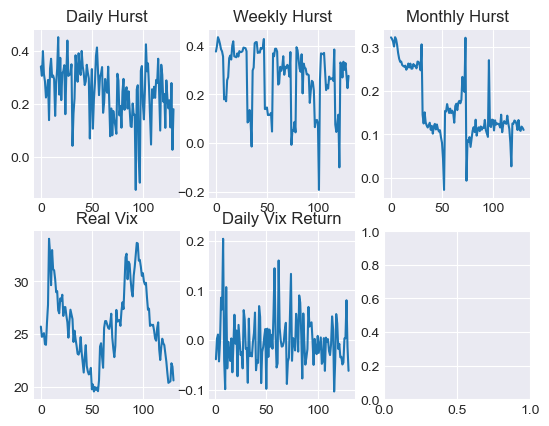

In [365]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 3)
  
# Prepare for the sub plots
axis[0, 0].plot(final_data['H_Daily'])
axis[0, 0].set_title('Daily Hurst')

axis[0, 1].plot(final_data['H_Weekly'])
axis[0, 1].set_title('Weekly Hurst')
  
axis[0, 2].plot(final_data['H_Monthly'])
axis[0, 2].set_title('Monthly Hurst')

axis[1, 0].plot(final_data['Real_VIX'])
axis[1, 0].set_title('Real Vix')

axis[1, 1].plot(final_data['Return_VIX'])
axis[1, 1].set_title('Daily Vix Return')
  
# Combine all the operations and display
plt.show()

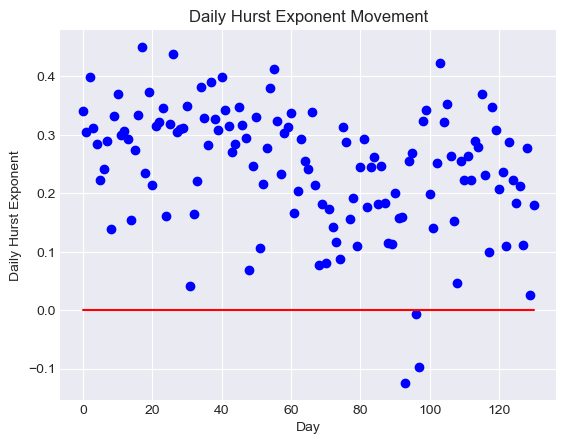

In [307]:
# Detect abnormal (negative) Hurst exponents
plot_x = X = np.arange(0, 131, 1)

plt.scatter(plot_x, final_data['H_Daily'], c='b')
plt.plot(plot_x, [0]*131, c='r')
plt.title('Daily Hurst Exponent Movement')
plt.xlabel('Day')
plt.ylabel('Daily Hurst Exponent')

plt.show()

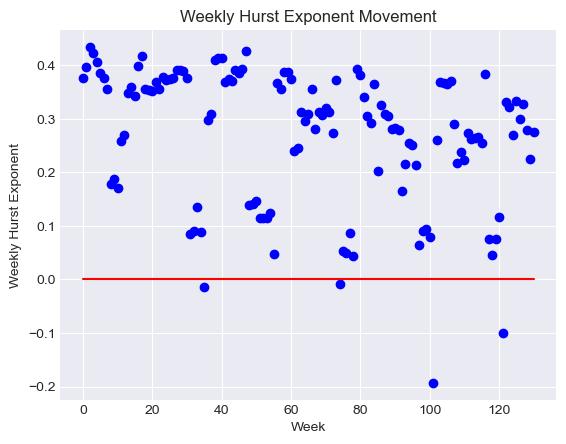

In [308]:
plt.scatter(plot_x, final_data['H_Weekly'], c='b')
plt.plot(plot_x, [0]*131, c='r')
plt.title('Weekly Hurst Exponent Movement')
plt.xlabel('Week')
plt.ylabel('Weekly Hurst Exponent')

plt.show()

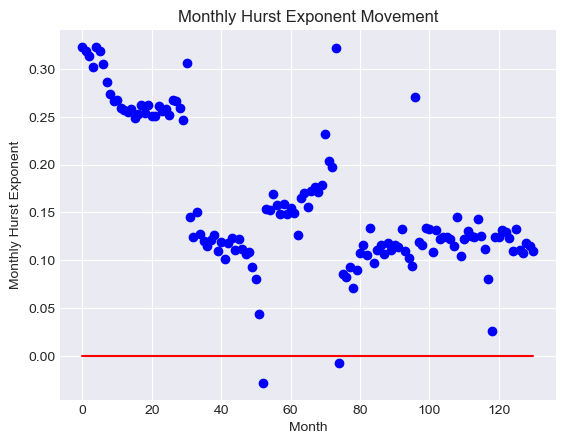

In [309]:
plt.scatter(plot_x, final_data['H_Monthly'], c='b')
plt.plot(plot_x, [0]*131, c='r')
plt.title('Monthly Hurst Exponent Movement')
plt.xlabel('Month')
plt.ylabel('Monthly Hurst Exponent')

plt.show()

We'll continue the study on the original data and work on removing the abnormal ones later

### Relationship between Hurst Exponents and VIX Index

#### OLS Regression

In [402]:
original_ols = final_data.copy()
original_ols['Target_VIX'] = original_ols['Real_VIX'].shift(-1)
original_ols.dropna(inplace=True)
original_ols

,H_Daily,H_Weekly,H_Monthly,Real_VIX,Return_VIX,Target_VIX
1,0.305039,0.397399,0.318993,24.72,-0.038489,24.79
2,0.398033,0.434367,0.313139,24.79,0.002828,25.07
3,0.311613,0.423186,0.301598,25.07,0.011232,24.02
4,0.284530,0.406213,0.323090,24.02,-0.042785,23.96
5,0.223343,0.384806,0.318403,23.96,-0.002501,26.09
6,0.240975,0.376020,0.305096,26.09,0.085166,27.75
7,0.289382,0.354920,0.286574,27.75,0.061684,34.02
8,0.138345,0.178762,0.273674,34.02,0.203713,32.69
9,0.332009,0.188301,0.266403,32.69,-0.039879,29.62
10,0.369180,0.171119,0.267172,29.62,-0.098619,32.95


In [403]:
original_Y_ols = original_ols['Target_VIX']
original_X_ols = original_ols[['H_Daily', 'H_Weekly', 'H_Monthly']]
original_X_ols = sm.add_constant(original_X_ols)
original_model_ols = sm.OLS(original_Y_ols, original_X_ols)
original_results_ols = original_model_ols.fit()

print(original_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:             Target_VIX   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     5.974
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           0.000772
Time:                        17:41:20   Log-Likelihood:                -341.39
No. Observations:                 129   AIC:                             690.8
Df Residuals:                     125   BIC:                             702.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.9587      0.986     26.326      0.0

In [405]:
# Predict VIX return based on Hurst expononents
original_Y_ols_1 = original_ols['Return_VIX']
original_X_ols_1 = original_ols[['H_Daily', 'H_Weekly', 'H_Monthly']]
original_X_ols_1 = sm.add_constant(original_X_ols_1)
original_model_ols_1 = sm.OLS(original_Y_ols_1, original_X_ols_1)
original_results_ols_1 = original_model_ols_1.fit()

print(original_results_ols_1.summary())

                            OLS Regression Results                            
Dep. Variable:             Return_VIX   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.4592
Date:                Thu, 17 Aug 2023   Prob (F-statistic):              0.711
Time:                        17:42:37   Log-Likelihood:                 201.79
No. Observations:                 129   AIC:                            -395.6
Df Residuals:                     125   BIC:                            -384.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0087      0.015      0.597      0.5

In [404]:
# Remove H_Weekly, then conduct the OLS regression again
original_Y_ols_2 = original_ols['Target_VIX']
original_X_ols_2 = original_ols[['H_Daily', 'H_Monthly']]
original_X_ols_2 = sm.add_constant(original_X_ols_2)
original_model_ols_2 = sm.OLS(original_Y_ols_2, original_X_ols_2)
original_results_ols_2 = original_model_ols_2.fit()

print(original_results_ols_2.summary())

                            OLS Regression Results                            
Dep. Variable:             Target_VIX   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     8.401
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           0.000376
Time:                        17:41:35   Log-Likelihood:                -341.96
No. Observations:                 129   AIC:                             689.9
Df Residuals:                     126   BIC:                             698.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.6604      0.945     27.162      0.0

#### Predict the Movement Direction of VIX

Support Vector Machine (SVM)

In [374]:
direction_vix_svm = final_data.copy()

,H_Daily,H_Weekly,H_Monthly,Real_VIX,Return_VIX
0,0.340135,0.375200,0.322655,25.69,NaN
1,0.305039,0.397399,0.318993,24.72,-0.038489
2,0.398033,0.434367,0.313139,24.79,0.002828
3,0.311613,0.423186,0.301598,25.07,0.011232
4,0.284530,0.406213,0.323090,24.02,-0.042785
5,0.223343,0.384806,0.318403,23.96,-0.002501
6,0.240975,0.376020,0.305096,26.09,0.085166
7,0.289382,0.354920,0.286574,27.75,0.061684
8,0.138345,0.178762,0.273674,34.02,0.203713
9,0.332009,0.188301,0.266403,32.69,-0.039879


In [375]:
# Store all predictor variables in a variable X
X = direction_vix_svm[['H_Daily', 'H_Weekly', 'H_Monthly']]

# Definining the target variables
y = np.where(direction_vix_svm['Real_VIX'].shift(-1) > direction_vix_svm['Real_VIX'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Preedict code
direction_vix_svm['Predicted_Signal'] = cls.predict(X)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
cls.score(X_test, y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- H_Daily
- H_Monthly
- H_Weekly
Feature names seen at fit time, yet now missing:
- delta_H_D
- delta_H_M
- delta_H_W

  warnings.warn(message, FutureWarning)


0.4444444444444444

In [376]:
# Cross validation
scores = cross_val_score(cls, X, y, cv=5)
print(scores)

[0.55555556 0.57692308 0.57692308 0.57692308 0.53846154]


In [378]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.56 accuracy with a standard deviation of 0.02


Scale the datasets, then perform the SVM again

In [381]:
scaling_minmax = MinMaxScaler()
scaled_direction_vix_svm = final_data.copy()
scaled_direction_vix_svm = scaling_minmax.fit_transform(scaled_direction_vix_svm)
scaled_direction_vix_svm = pd.DataFrame(scaled_direction_vix_svm, 
                                        columns=['H_Daily', 'H_Weekly', 'H_Monthly', 'Real_VIX', 'Return_VIX'])
scaled_direction_vix_svm

,H_Daily,H_Weekly,H_Monthly,Real_VIX,Return_VIX
0,0.808173,0.905686,0.998761,0.425121,NaN
1,0.747115,0.941073,0.988333,0.358178,0.211039
2,0.908902,1.000000,0.971662,0.363009,0.345627
3,0.758551,0.982178,0.938797,0.382333,0.373002
4,0.711434,0.955122,1.000000,0.309869,0.197046
5,0.604984,0.920999,0.986651,0.305728,0.328269
6,0.635659,0.906993,0.948760,0.452726,0.613841
7,0.719875,0.873360,0.896016,0.567288,0.537348
8,0.457107,0.592558,0.859280,1.000000,1.000000
9,0.794036,0.607764,0.838575,0.908213,0.206511


In [382]:
# Store all predictor variables in a variable X
X = scaled_direction_vix_svm[['H_Daily', 'H_Weekly', 'H_Monthly']]

# Definining the target variables
y = np.where(scaled_direction_vix_svm['Real_VIX'].shift(-1) > scaled_direction_vix_svm['Real_VIX'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
cls.score(X_test, y_test)

0.4444444444444444

In [383]:
# Cross validation
scores = cross_val_score(cls, X, y, cv=5)
print(scores)

[0.55555556 0.57692308 0.57692308 0.57692308 0.53846154]


In [384]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.56 accuracy with a standard deviation of 0.02


The scaling above shows that it didn't improve the prediction ability

Visualize the SVM Prediction

In [387]:
direction_vix_svm

,H_Daily,H_Weekly,H_Monthly,Real_VIX,Return_VIX,Predicted_Signal,VIX_Return
0,0.340135,0.375200,0.322655,25.69,NaN,0,NaN
1,0.305039,0.397399,0.318993,24.72,-0.038489,0,-0.038489
2,0.398033,0.434367,0.313139,24.79,0.002828,0,0.002828
3,0.311613,0.423186,0.301598,25.07,0.011232,0,0.011232
4,0.284530,0.406213,0.323090,24.02,-0.042785,0,-0.042785
5,0.223343,0.384806,0.318403,23.96,-0.002501,0,-0.002501
6,0.240975,0.376020,0.305096,26.09,0.085166,0,0.085166
7,0.289382,0.354920,0.286574,27.75,0.061684,0,0.061684
8,0.138345,0.178762,0.273674,34.02,0.203713,0,0.203713
9,0.332009,0.188301,0.266403,32.69,-0.039879,0,-0.039879


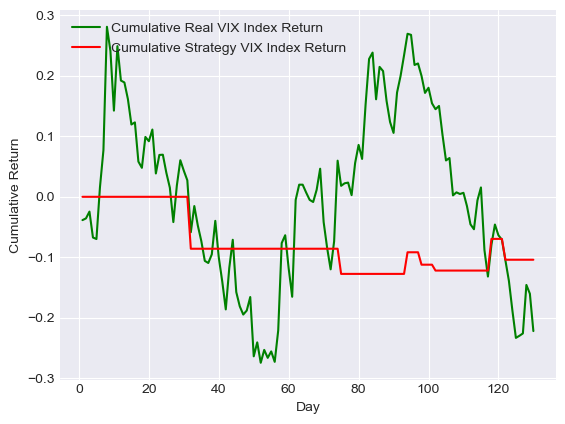

In [388]:
# Calculate strategy returns
direction_vix_svm['Strategy_Return'] = direction_vix_svm.Return_VIX * direction_vix_svm.Predicted_Signal.shift(1)

# Calculate Cumulutive returns
direction_vix_svm['Cum_VIX_Ret'] = direction_vix_svm['Return_VIX'].cumsum()
direction_vix_svm['Cum_Strategy'] = direction_vix_svm['Strategy_Return'].cumsum()

# Plot Strategy Returns vs Original Returns
plt.plot(direction_vix_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(direction_vix_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

### Predict the Hurst Exponent

#### OLS Regression

In [389]:
# Create a new dataframe to analyze relationships between Hurst exponents at different time spots
H_est = pd.DataFrame()
H_est['H_Daily'] = final_data['H_Daily'].copy()
H_est['H_Weekly'] = final_data['H_Weekly'].copy()
H_est['H_Monthly'] = final_data['H_Monthly'].copy()
H_est['Target_H_Daily'] = final_data['H_Daily'].shift(-1)
H_est.dropna(inplace=True)

H_est

,H_Daily,H_Weekly,H_Monthly,Target_H_Daily
0,0.340135,0.375200,0.322655,0.305039
1,0.305039,0.397399,0.318993,0.398033
2,0.398033,0.434367,0.313139,0.311613
3,0.311613,0.423186,0.301598,0.284530
4,0.284530,0.406213,0.323090,0.223343
5,0.223343,0.384806,0.318403,0.240975
6,0.240975,0.376020,0.305096,0.289382
7,0.289382,0.354920,0.286574,0.138345
8,0.138345,0.178762,0.273674,0.332009
9,0.332009,0.188301,0.266403,0.369180


In [390]:
H_est_ols = H_est.copy()

H_est_Y_ols = H_est_ols['Target_H_Daily']
H_est_X_ols = H_est_ols[['H_Daily', 'H_Weekly', 'H_Monthly']]
H_est_X_ols = sm.add_constant(H_est_X_ols)
H_est_model_ols = sm.OLS(H_est_Y_ols, H_est_X_ols)
H_est_results_ols = H_est_model_ols.fit()

print(H_est_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:         Target_H_Daily   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     4.482
Date:                Thu, 17 Aug 2023   Prob (F-statistic):            0.00503
Time:                        17:38:13   Log-Likelihood:                 117.62
No. Observations:                 130   AIC:                            -227.2
Df Residuals:                     126   BIC:                            -215.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1657      0.028      5.898      0.0

In [326]:
# Remove H_Weekly and H_Monthly, then perform the OLS regression again
H_est_ols_2 = H_est.copy()

H_est_Y_ols_2 = H_est_ols_2['Target_H_Daily']
H_est_X_ols_2 = H_est_ols_2[['H_Daily']]
H_est_X_ols_2 = sm.add_constant(H_est_X_ols_2)
H_est_model_ols_2 = sm.OLS(H_est_Y_ols_2, H_est_X_ols_2)
H_est_results_ols_2 = H_est_model_ols_2.fit()

print(H_est_results_ols_2.summary())

                            OLS Regression Results                            
Dep. Variable:         Target_H_Daily   R-squared:                       0.095
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     13.45
Date:                Thu, 17 Aug 2023   Prob (F-statistic):           0.000358
Time:                        17:08:02   Log-Likelihood:                 117.52
No. Observations:                 130   AIC:                            -231.0
Df Residuals:                     128   BIC:                            -225.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1690      0.022      7.549      0.0

## Analyze the percentage change

In [391]:
final_data_diff = pd.DataFrame()

final_data_diff['delta_H_D'] = np.log(final_data['H_Daily']).diff()
final_data_diff['delta_H_W'] = np.log(final_data['H_Weekly']).diff()
final_data_diff['delta_H_M'] = np.log(final_data['H_Monthly']).diff()
final_data_diff['delta_Real_V'] = np.log(final_data['Real_VIX']).diff()

final_data_diff.dropna(inplace=True)
final_data_diff

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,delta_H_D,delta_H_W,delta_H_M,delta_Real_V
1,-0.108902,0.057482,-0.011414,-0.038489
2,0.266096,0.088948,-0.018523,0.002828
3,-0.244775,-0.026077,-0.037553,0.011232
4,-0.090921,-0.040934,0.068838,-0.042785
5,-0.242130,-0.054139,-0.014615,-0.002501
6,0.075984,-0.023098,-0.042689,0.085166
7,0.183054,-0.057748,-0.062629,0.061684
8,-0.737999,-0.685840,-0.046060,0.203713
9,0.875414,0.051990,-0.026928,-0.039879
10,0.106122,-0.095681,0.002882,-0.098619


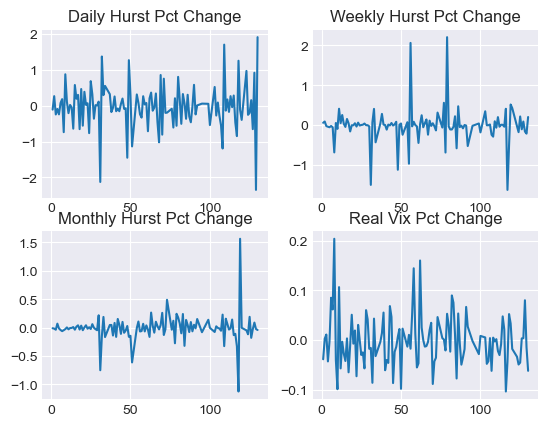

In [392]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# For Sine Function
axis[0, 0].plot(final_data_diff['delta_H_D'])
axis[0, 0].set_title('Daily Hurst Pct Change')
  
# For Cosine Function
axis[0, 1].plot(final_data_diff['delta_H_W'])
axis[0, 1].set_title('Weekly Hurst Pct Change')
  
# For Tangent Function
axis[1, 0].plot(final_data_diff['delta_H_M'])
axis[1, 0].set_title('Monthly Hurst Pct Change')
  
# For Tanh Function
axis[1, 1].plot(final_data_diff['delta_Real_V'])
axis[1, 1].set_title('Real Vix Pct Change')
  
# Combine all the operations and display
plt.show()

In [393]:
# Remove those over pct change data points three standard deviation away from mean
# A general function to remove the outliers by ZSCORE method
def remove_outliers(df, col, threshold=1.68):
    z_scores = np.abs((df[col] - df[col].mean()) / df[col].std())
    filtered_df = df[(z_scores < threshold).all(axis=1)]
    return filtered_df

filtered_final_diff = remove_outliers(final_data_diff[1:], ['delta_H_D', 'delta_H_W', 'delta_H_M', 'delta_Real_V'])
filtered_final_diff

,delta_H_D,delta_H_W,delta_H_M,delta_Real_V
2,0.266096,0.088948,-0.018523,0.002828
3,-0.244775,-0.026077,-0.037553,0.011232
4,-0.090921,-0.040934,0.068838,-0.042785
5,-0.242130,-0.054139,-0.014615,-0.002501
6,0.075984,-0.023098,-0.042689,0.085166
7,0.183054,-0.057748,-0.062629,0.061684
9,0.875414,0.051990,-0.026928,-0.039879
12,0.020900,0.048166,-0.008248,-0.056819
13,-0.046694,0.252580,-0.006292,-0.003218
14,-0.640237,0.030137,0.009030,-0.027444


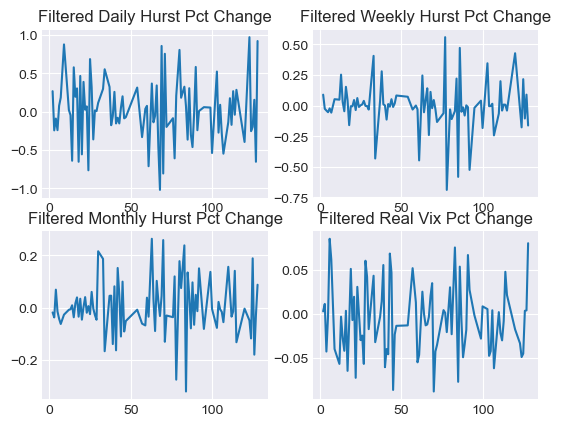

In [394]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(2, 2)
  
# For Sine Function
axis[0, 0].plot(filtered_final_diff['delta_H_D'])
axis[0, 0].set_title('Filtered Daily Hurst Pct Change')
  
# For Cosine Function
axis[0, 1].plot(filtered_final_diff['delta_H_W'])
axis[0, 1].set_title('Filtered Weekly Hurst Pct Change')
  
# For Tangent Function
axis[1, 0].plot(filtered_final_diff['delta_H_M'])
axis[1, 0].set_title('Filtered Monthly Hurst Pct Change')
  
# For Tanh Function
axis[1, 1].plot(filtered_final_diff['delta_Real_V'])
axis[1, 1].set_title('Filtered Real Vix Pct Change')
  
# Combine all the operations and display
plt.show()

### Predict VIX Movement

Filtered data OLS regression

In [395]:
filtered_ols = filtered_final_diff.copy()

filtered_Y_ols = filtered_ols['delta_Real_V']
# filtered_X_ols = filtered_ols[['delta_H_D']]
filtered_X_ols = filtered_ols[['delta_H_D', 'delta_H_W', 'delta_H_M']]
filtered_X_ols = sm.add_constant(filtered_X_ols)
filtered_model_ols = sm.OLS(filtered_Y_ols, filtered_X_ols)
filtered_results_ols = filtered_model_ols.fit()

print(filtered_results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:           delta_Real_V   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     1.808
Date:                Thu, 17 Aug 2023   Prob (F-statistic):              0.152
Time:                        17:39:04   Log-Likelihood:                 165.30
No. Observations:                  90   AIC:                            -322.6
Df Residuals:                      86   BIC:                            -312.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.004     -1.417      0.1

SVM

In [396]:
pct_vix_svm = filtered_final_diff.copy()

# Store all predictor variables in a variable X
X = pct_vix_svm[['delta_H_D', 'delta_H_W', 'delta_H_M']]

# Definining the target variables
y = np.where(pct_vix_svm['delta_Real_V'].shift(-1) > pct_vix_svm['delta_Real_V'], 1, 0)

# Data splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Perform the SVM
cls = SVC(kernel='linear', C=1).fit(X_train, y_train)
cls.score(X_test, y_test)

0.6666666666666666

In [397]:
# Cross validation
scores = cross_val_score(cls, X, y, cv=5)
print(scores)

[0.61111111 0.44444444 0.61111111 0.55555556 0.72222222]


In [398]:
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.59 accuracy with a standard deviation of 0.09


In [399]:
pct_vix_svm

,delta_H_D,delta_H_W,delta_H_M,delta_Real_V
2,0.266096,0.088948,-0.018523,0.002828
3,-0.244775,-0.026077,-0.037553,0.011232
4,-0.090921,-0.040934,0.068838,-0.042785
5,-0.242130,-0.054139,-0.014615,-0.002501
6,0.075984,-0.023098,-0.042689,0.085166
7,0.183054,-0.057748,-0.062629,0.061684
9,0.875414,0.051990,-0.026928,-0.039879
12,0.020900,0.048166,-0.008248,-0.056819
13,-0.046694,0.252580,-0.006292,-0.003218
14,-0.640237,0.030137,0.009030,-0.027444


Visualize

In [400]:
# Predict the signals
pct_vix_svm['Predicted_Signal'] = cls.predict(X)

# Calculate daily returns
pct_vix_svm['VIX_Return'] = pct_vix_svm['delta_Real_V']

# Calculate strategy returns
pct_vix_svm['Strategy_Return'] = pct_vix_svm.VIX_Return * pct_vix_svm.Predicted_Signal.shift(1)

# Calculate Cumulutive returns
pct_vix_svm['Cum_VIX_Ret'] = pct_vix_svm['VIX_Return'].cumsum()
pct_vix_svm['Cum_Strategy'] = pct_vix_svm['Strategy_Return'].cumsum()

In [337]:
pct_vix_svm

,delta_H_D,delta_H_W,delta_H_M,delta_Real_V,Predicted_Signal,VIX_Return,Strategy_Return,Cum_VIX_Ret,Cum_Strategy
2,0.266096,0.088948,-0.018523,0.002828,0,0.002828,NaN,0.002828,NaN
3,-0.244775,-0.026077,-0.037553,0.011232,1,0.011232,0.000000,0.014059,0.000000
4,-0.090921,-0.040934,0.068838,-0.042785,1,-0.042785,-0.042785,-0.028726,-0.042785
5,-0.242130,-0.054139,-0.014615,-0.002501,1,-0.002501,-0.002501,-0.031227,-0.045286
6,0.075984,-0.023098,-0.042689,0.085166,1,0.085166,0.085166,0.053939,0.039880
7,0.183054,-0.057748,-0.062629,0.061684,1,0.061684,0.061684,0.115623,0.101564
9,0.875414,0.051990,-0.026928,-0.039879,0,-0.039879,-0.039879,0.075744,0.061685
12,0.020900,0.048166,-0.008248,-0.056819,1,-0.056819,-0.000000,0.018925,0.061685
13,-0.046694,0.252580,-0.006292,-0.003218,0,-0.003218,-0.003218,0.015707,0.058467
14,-0.640237,0.030137,0.009030,-0.027444,1,-0.027444,-0.000000,-0.011737,0.058467


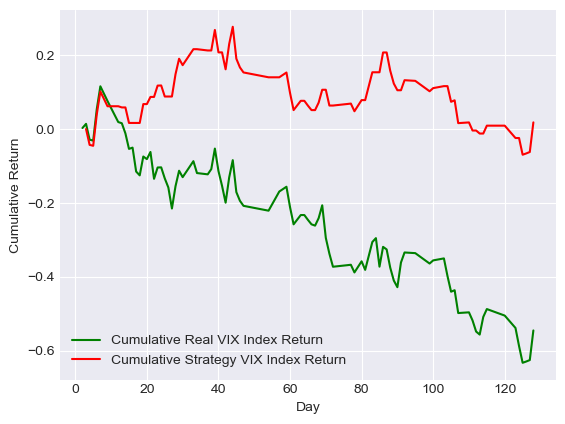

In [401]:
# Plot Strategy Returns vs Original Returns
plt.plot(pct_vix_svm['Cum_VIX_Ret'], color='green', label='Cumulative Real VIX Index Return')
plt.plot(pct_vix_svm['Cum_Strategy'], color='red', label='Cumulative Strategy VIX Index Return')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Cumulative Return')
plt.show()

The above analyses show no apparent relationships between Hurst exponents and VIX index. Let's see if we can trade VIX based on Hurst exponent signals.

# Future Study

The number of dataset on daily, weekly and monthly bases are not even due to (1) uncontinuous data (interval greater than one minute); (2) change of daylight saving time; (3) holidays of different countries and; (4) time zones (the date of of VIX index closing price is not always the same as GMT). Future study will (1) fill the missing data using systematic approaches, e.g., interpolation; (2) 

<AxesSubplot:xlabel='Time'>

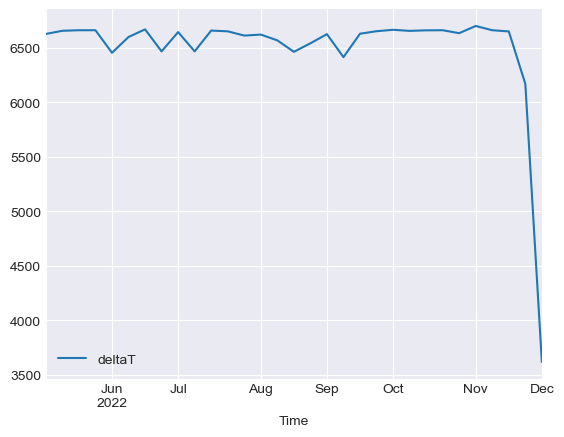

In [339]:
# Weekly data availability fluctuates
available_weekly.plot()

day_of_week
0    AxesSubplot(0.125,0.11;0.775x0.77)
1    AxesSubplot(0.125,0.11;0.775x0.77)
2    AxesSubplot(0.125,0.11;0.775x0.77)
3    AxesSubplot(0.125,0.11;0.775x0.77)
4    AxesSubplot(0.125,0.11;0.775x0.77)
5    AxesSubplot(0.125,0.11;0.775x0.77)
6    AxesSubplot(0.125,0.11;0.775x0.77)
dtype: object

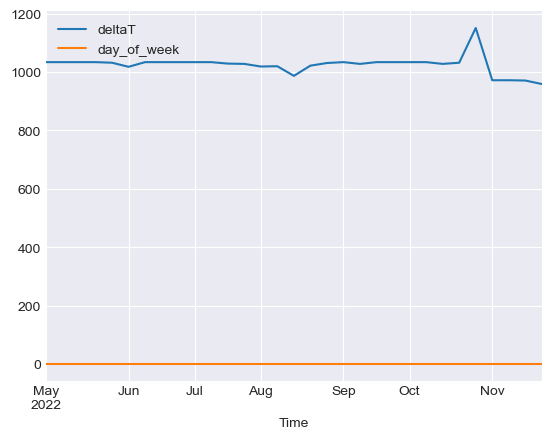

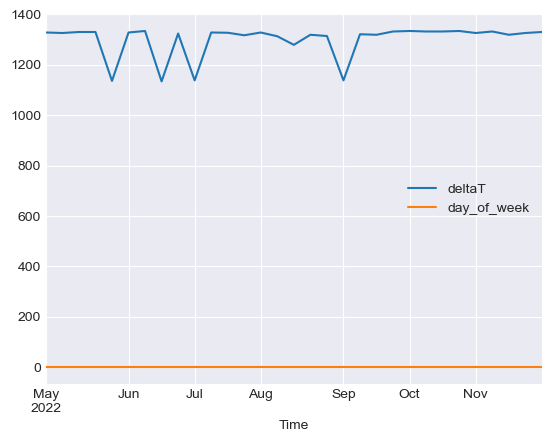

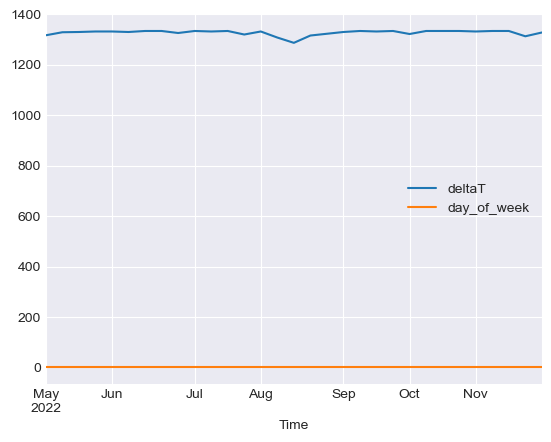

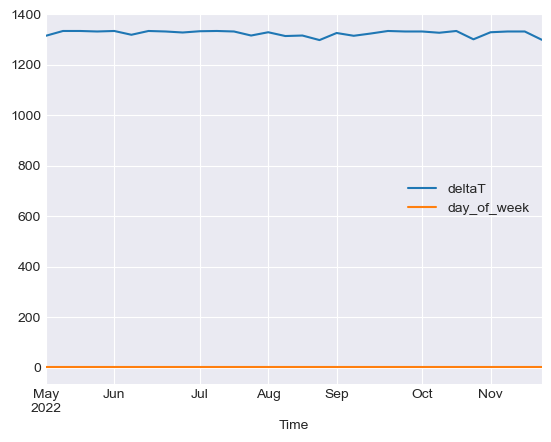

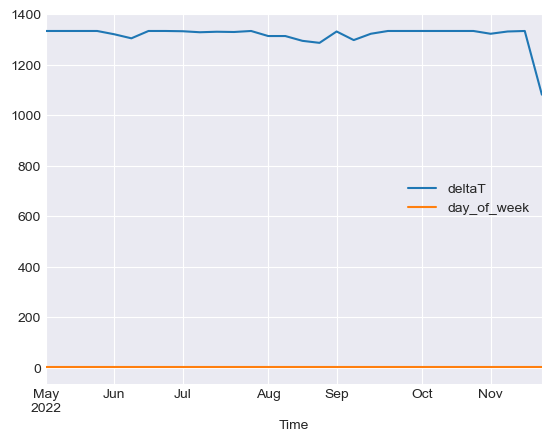

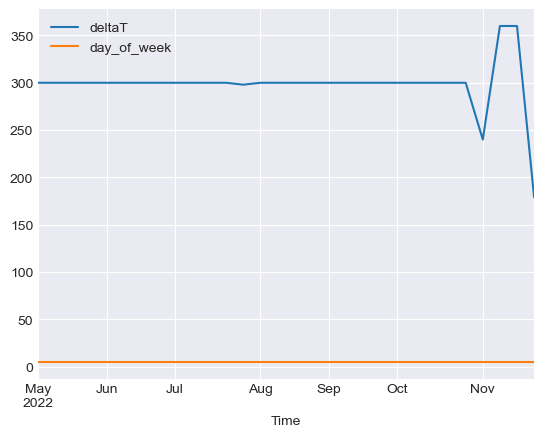

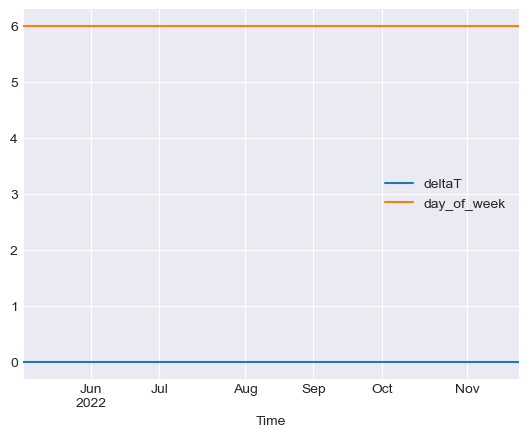

In [351]:
# Daily data ability fluctuates
available_daily.groupby(['day_of_week']).plot()

<AxesSubplot:xlabel='Time'>

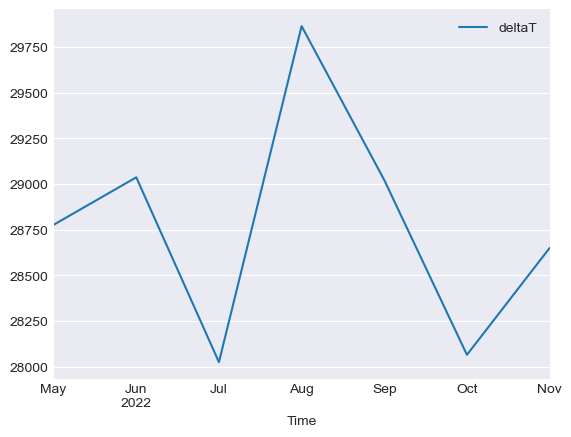

In [341]:
available_monthly.plot()

#### Investigate negative H_Daily values

In [355]:
positive_final = final_data.copy()
index_Daily = positive_final[positive_final['H_Daily'] < 0].index
positive_final.drop(index_Daily)
index_Daily = positive_final[positive_final['H_Daily'] < 0].index

,H_Daily,H_Weekly,H_Monthly,Real_VIX
0,0.340135,0.375200,0.322655,25.69
1,0.305039,0.397399,0.318993,24.72
2,0.398033,0.434367,0.313139,24.79
3,0.311613,0.423186,0.301598,25.07
4,0.284530,0.406213,0.323090,24.02
5,0.223343,0.384806,0.318403,23.96
6,0.240975,0.376020,0.305096,26.09
7,0.289382,0.354920,0.286574,27.75
8,0.138345,0.178762,0.273674,34.02
9,0.332009,0.188301,0.266403,32.69


<AxesSubplot:>

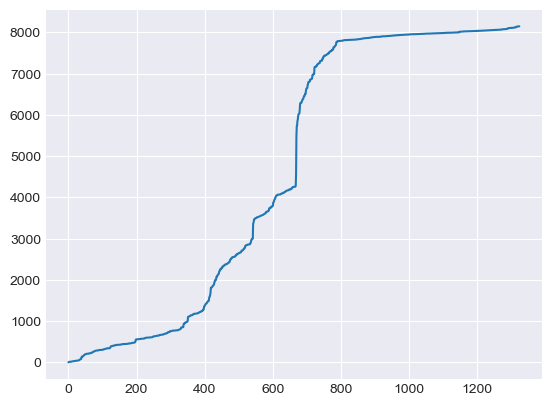

In [342]:
daily_cumsum[126].plot()

In [343]:
# Define parameters
n_sample = avg_daily
scales = np.unique(np.logspace(np.log10(3), np.log10((n_sample+1)/10), 50).astype(int))
num_obs = 131

In [344]:
# Prepare the final dataframe to analyze
final_data_cols = ['H_Daily', 'H_Weekly', 'H_Monthly', 'Real_VIX', 'Estimate__VIX']
final_data1 = pd.DataFrame(index=np.arange(num_obs), columns=final_data_cols)
final_data1

,H_Daily,H_Weekly,H_Monthly,Real_VIX,Estimate__VIX
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN


In [345]:
# Create DMA flucuation function dataframe
F_summary_columns = []
for q in qs:
    for col in [11, 126]:
        F_summary_columns.append('q_'+str(q)+'_'+str(col))

F_summary_index = []
for scale in scales:
    F_summary_index.append('s_'+str(scale))

F_summary_daily1 = pd.DataFrame(index=F_summary_index, columns=F_summary_columns)
F_summary_daily1

,q_2.0_11,q_2.0_126
s_3,NaN,NaN
s_4,NaN,NaN
s_5,NaN,NaN
s_6,NaN,NaN
s_7,NaN,NaN
s_8,NaN,NaN
s_9,NaN,NaN
s_10,NaN,NaN
s_11,NaN,NaN
s_12,NaN,NaN


In [346]:
starttime_total = time.time()

log10_scale = np.log10(scales)

for col in [11, 126]:
    ana_temp = daily_cumsum[col]
    
    for scale in scales:
        # Calculate moving average
        mean_temp = []
        for i in range(n_sample-scale+1):
            mean_temp.append(np.mean(ana_temp[i:i+scale]))
        mean_temp.reverse()
        
        # Detrend
        diff_temp_subtractor = ana_temp[:scale-2:-1].values
        diff_temp = np.subtract(np.array(mean_temp), diff_temp_subtractor)
        
        # Slice into non-overlapping segments
        segs_temp = pd.DataFrame(np.resize(diff_temp, (len(diff_temp) // scale, scale))).T
        
        # Calculate fluctuation variance
        F_seg_sq_temp = np.array(np.var(segs_temp).mean(axis=0))
        
        # Calculate the qth order fluctuation function
        for q in qs:
            if q != 0.0:
                F_temp =  ((1 / scale) * (F_seg_sq_temp ** (q / 2)).sum()) ** (1 / q)
            else:
                F_temp = np.exp(np.log(F_seg_sq_temp ** (1 / 2)).mean()) # L’Hôspital’s rule when q = 0
            
            F_summary_daily1.loc[str('s_'+str(scale))][str('q_'+str(q))+'_'+str(col)] = F_temp
       
    # Calculate Hurst exponent
    log10_F = np.log10(np.array(F_summary_daily1[str('q_'+str(q))+'_'+str(col)]).astype(float))
    hurst_hat = np.polyfit(log10_scale, log10_F, 1)[0]
    final_data1['H_Daily'][col] = hurst_hat
    
    if (col+1) % 10 == 0:
        endtime_total = time.time()
        total_time = endtime_total - starttime_total
        print(f'{col+1} out of {num_obs} columns are done,', f'total time spent till now is',
              f'{int((endtime_total-starttime_total)//60)} min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

endtime_total = time.time()
total_time = endtime_total - starttime_total
print(f'All done! Total time spent is',f'{int((endtime_total-starttime_total)//60)}',
      f'min(s) {int((endtime_total-starttime_total) % 60)} sec(s).')

All done! Total time spent is 0 min(s) 12 sec(s).


In [347]:
F_summary_daily1

,q_2.0_11,q_2.0_126
s_3,89.214298,10.32791
s_4,64.029573,8.488281
s_5,104.034507,9.964765
s_6,93.96868,13.749563
s_7,105.067265,13.079615
s_8,112.046693,9.235988
s_9,107.297156,10.858274
s_10,107.120818,15.634873
s_11,97.971095,15.445746
s_12,129.883365,15.436545


In [348]:
final_data[(final_data['H_Daily']<0) | (final_data['H_Weekly']<0) | (final_data['H_Monthly']<0)]

,H_Daily,H_Weekly,H_Monthly,Real_VIX
35,0.328233,-0.014928,0.119917,23.88
52,0.215852,0.115319,-0.028077,19.53
74,0.086789,-0.007932,-0.006916,27.27
93,-0.124398,0.215077,0.109304,32.45
96,-0.007163,0.214544,0.270155,31.94
97,-0.097272,0.064817,0.119247,32.02
101,0.140936,-0.192975,0.108629,29.98
121,0.236814,-0.100360,0.131528,23.93


In [349]:
final_data[(final_data[final_data.columns] < 0) | (final_data[final_data.columns].isnotna())]

AttributeError: 'DataFrame' object has no attribute 'isnotna'

In [ ]:
# Log-log plot and calculate H
log10_lag = np.log10(scales)
log10_F = np.log10(np.array(F_summary_daily1).astype(float)) 
hurst_hat = np.polyfit(log10_lag, log10_F, 1)[0]
# hurst_hat = np.polyfit(log10_lag[:29], log10_F[:29], 1)[0]

plt.plot(log10_lag, log10_F, marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
# plt.plot(log10_lag[:29], log10_F[:29], marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.show()

How to fix? Method one: delete the negative H_Daily values

In [ ]:
# # Remove rows containing negative daily Hurst exponents (index 11 and 126)
# indexAge = final_data[final_data['H_Daily'] < 0].index
# final_data.drop(indexAge, inplace=True)
# final_data

# # Reset index
# final_for_ml = pd.DataFrame(final_data.to_numpy(), columns=final_data_cols)

How to fix? Method one: only use uptrended data

In [ ]:
# Log-log plot and calculate H
log10_lag = np.log10(scales)
log10_F = np.log10(np.array(F_summary_daily1).astype(float)) 
hurst_hat = np.polyfit(log10_lag[:29], log10_F[:29], 1)[0]

plt.plot(log10_lag[:29], log10_F[:29], marker="o", markersize=3, markeredgecolor="red", markerfacecolor="green")
plt.xlabel('Log_s')
plt.ylabel('Log_F(s)')
plt.show()